<h2>1. Imports</h1>

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import time
import matplotlib.pyplot as plt

<h2>2. Global definitions & helpers</h1>

In [ ]:
Z_DIMS = 8 #number of random values to put into our GAN
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(mnist_trainset, batch_size=64, shuffle=True)

def show(img):
    assert(len(img.size()) == 3)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.show()
for img, label in train_loader:
    #show example image:
    show(img[0])
    break

<h2>3. Network architecture </h1>

In [27]:
#trivial risidual block: apply convolution twice, then add the original input projected to the output size
#tl;dr "do some computation, then add the original input to the result to make sure our gradients are somewhat stable and we train without vanishing gradients"
class ResBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, skip_last_relu=False):
        super(ResBlock, self).__init__()
        #without bias & with kernel size 1, this is effectively just "projecting" the input to the output size without doing much. this can also scale that residual just to zero if we want
        self.conv_res = torch.nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0, stride=1, bias=False)

        self.conv_1 = torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=1)
        self.conv_2 = torch.nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=1)
        #leaky relu = better gradient flow / prevention of "dead" neurons that do not change anymore
        self.relu_1 = torch.nn.LeakyReLU(negative_slope=0.01) #slope 0.01 basically means: "max(x, 0.01 * x)", i.e. if we are < 0, then we do not clamp to 0, but to 0.01 * x (e.g. -5 gets clamped to -0.05)
        self.relu_2 = torch.nn.LeakyReLU(negative_slope=0.01)
        if skip_last_relu:
            #our target values we want to generate are between [-1, 1] - applying (leaky) relu would basically (soft) clamp us to [0, inf);
            #hence, in those cases, just do nothing. that's faster than some ugly "if"-branch in the forward method
            self.relu_2 = torch.nn.Identity()
    
    def forward(self, x):
        x_res = self.conv_res(x)
        
        x = self.relu_1(self.conv_1(x))
        x = self.relu_2(self.conv_2(x))
        x = x + x_res
        return x

#simple generator: take random noise, process it a bit ("let the generator decide on what it should generate"), then upscale/residual block it until we reach target size
class Generator(torch.nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        #first part: generate a 7x7 base image from random noise
        self.lin_res = torch.nn.Linear(Z_DIMS + 8, 16*7*7, bias=False)
        self.lin_1 = torch.nn.Linear(Z_DIMS + 8, 128)
        self.lin_2 = torch.nn.Linear(128, 128)
        self.lin_3 = torch.nn.Linear(128, 16*7*7)

        #second part: alternate between residual blocks and upscaling until we reach target size
        self.res_1 = ResBlock(16, 64)
        self.res_2 = ResBlock(64, 64)
        self.res_3 = ResBlock(64, 1, skip_last_relu=True) #don't apply a relu at the end: we output images with values between [-1, 1], applying a relu would clamp us to [0, inf)

        #we use upsclaing, because transposed convolution layers create some ugly artifacts: https://distill.pub/2016/deconv-checkerboard/
        #just dumb upscaling and then applying a convolution layers does the same trick, just without artifacts
        self.upscale = torch.nn.Upsample(scale_factor=2.0, mode='bilinear')

        self.relu = torch.nn.LeakyReLU(negative_slope=0.01)

        #we put labels into our generator/discriminator to make it a conditional GAN, i.e. producing the numbers we want
        #for that, we use an embedding layer to project the labels into some higher space; just putting "8" in there is more difficult
        #for a network than putting a vector in there that represents "8" with multiple dimensions
        self.embedding = torch.nn.Embedding(10, 8)
        
    def forward(self, x, labels):
        #embed the labels into some higher dimentional space that's easier for our NN, then concatenate the labels to the input noise
        labels = self.embedding(labels)
        x = torch.cat([x, labels], dim=1)

        #take input vector, then project it to [b x 1 x 7 x 7]
        x_res = self.lin_res(x)
        x = self.relu(self.lin_1(x))
        x = self.relu(self.lin_2(x))
        x = self.relu(self.lin_3(x))
        x = x + x_res
        #re-shape so we have a [b x 16 x 7 x 7] tensor ("tiny" image with some channels)
        x = x.view(x.size()[0], 16, 7, 7)
        #second part: alternate between residual blocks and upscaling until we reach target size
        x = self.res_1(x)
        x = self.upscale(x)
        # now at [b x 64 x 14 x 14]
        x = self.res_2(x)
        x = self.upscale(x)
        # now at [b x 64 x 28 x 28]
        x = self.res_3(x)
        # now at [b x 1 x 28 x 28]
        return x

#simple discriminator: take an image, process it with a CNN, then output a value in roughly [-1, 1]
#basically, the generator architecture in reverse: interleave residual blocks and downscaling, then process with linear layers when information is dense enough
class Discriminator(torch.nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        #first part: process the image with our convolutional residual blocks
        self.res_1 = ResBlock(1+8, 64) #process image(1) and label embedding(8)
        self.res_2 = ResBlock(64, 64)
        self.res_3 = ResBlock(64, 16)
        self.downscale = torch.nn.Upsample(scale_factor=0.5, mode='bilinear') #same reason as for the upscaling: if we use convolutional layers, we get ugly artifacts. this is basically just avg pooling now
        #second part: process the image with linear layers
        self.lin_1 = torch.nn.Linear(16*7*7, 128)
        self.lin_2 = torch.nn.Linear(128, 128)
        self.lin_3 = torch.nn.Linear(128, 1)
        #for leaky relu here, use a slope of 0.1, because that gives us a bit more stable gradients:
        #the decision isn't as "harsh", hence the generator has an easier time to fix it's mistakes
        #(easier to "learn" the correct direction, i.e. if generator outputs are still wrong, but less wrong) 
        self.relu = torch.nn.LeakyReLU(negative_slope=0.1)

        self.embedding = torch.nn.Embedding(10, 8)

    def forward(self, x, labels):
        labels = self.embedding(labels)
        #simply concatenate the labels to every pixel of the image
        labels = labels.view(labels.size()[0], 8, 1, 1).repeat(1, 1, 28, 28)
        x = torch.cat([x, labels], dim=1)

        #first part: process the image with our convolutional residual blocks
        x = self.res_1(x)
        x = self.downscale(x)
        # now at [b x 64 x 14 x 14]
        x = self.res_2(x)
        x = self.downscale(x)
        # now at [b x 64 x 7 x 7]
        x = self.res_3(x)
        # now at [b x 16 x 7 x 7]
        x = x.view(x.size()[0], 16*7*7)
        #second part: process the image with linear layers; could also skip this part, giving us basically a patch-wise discriminator as done by many papers!
        x = self.relu(self.lin_1(x))
        x = self.relu(self.lin_2(x))
        x = self.lin_3(x) #no activation at the end - then we can get values in [-1, 1]
        return x

<h2>4. Training and inference</h1>

The generator has  258283  parameters
The discriminator has  250481  parameters
*** DONE WITH EPOCH 0  ***
	AVG loss discriminator:  1.3992581455342805
	AVG loss generator    :  1.7000240720679431


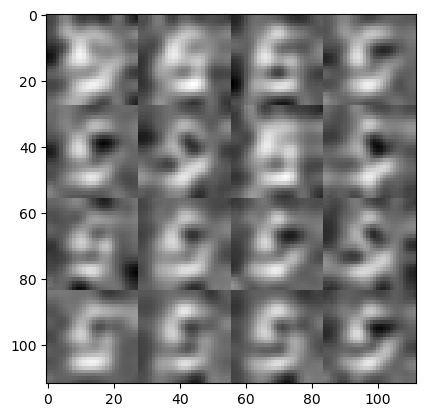

*** DONE WITH EPOCH 1  ***
	AVG loss discriminator:  0.27053654515770265
	AVG loss generator    :  3.3150365192498734


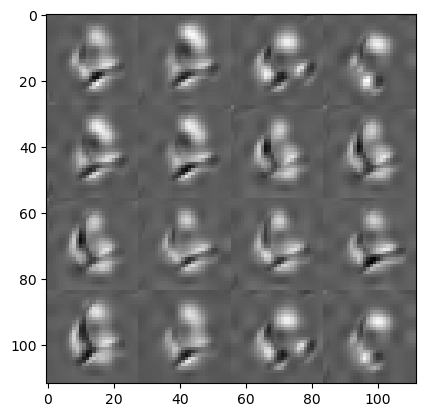

*** DONE WITH EPOCH 2  ***
	AVG loss discriminator:  0.21088269570453175
	AVG loss generator    :  3.6052972271498334


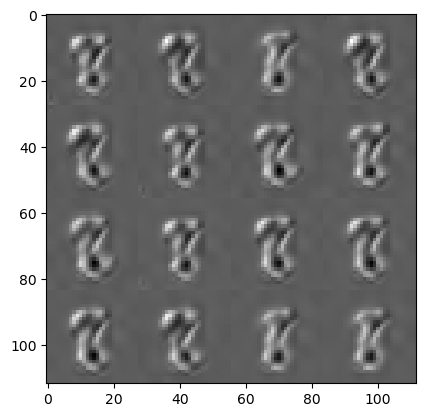

*** DONE WITH EPOCH 3  ***
	AVG loss discriminator:  0.18938482229286102
	AVG loss generator    :  3.2540336408848956


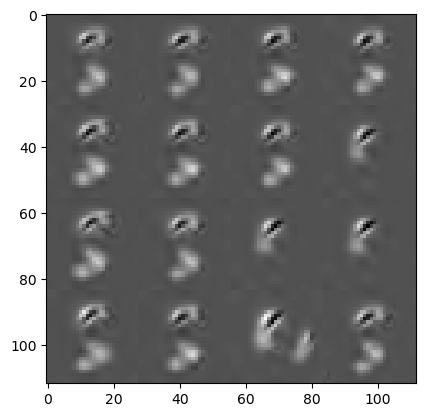

*** DONE WITH EPOCH 4  ***
	AVG loss discriminator:  0.1252796868962456
	AVG loss generator    :  3.5232583256418515


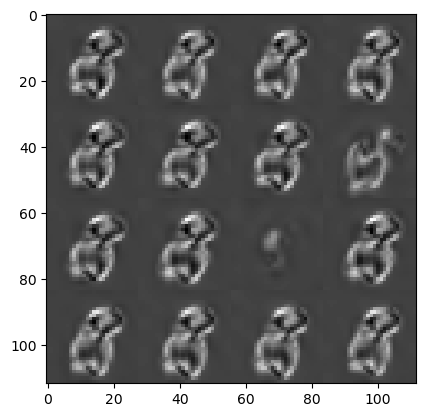

*** DONE WITH EPOCH 5  ***
	AVG loss discriminator:  0.07753809894135258
	AVG loss generator    :  3.7709608278803226


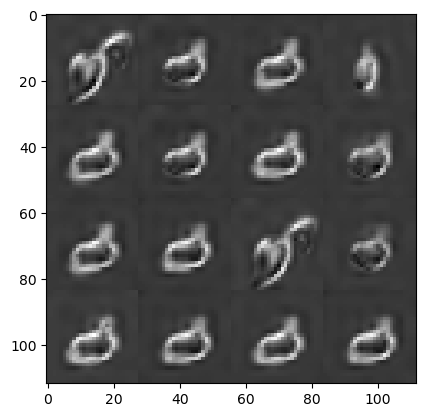

*** DONE WITH EPOCH 6  ***
	AVG loss discriminator:  0.09132695349076314
	AVG loss generator    :  3.77377477358145


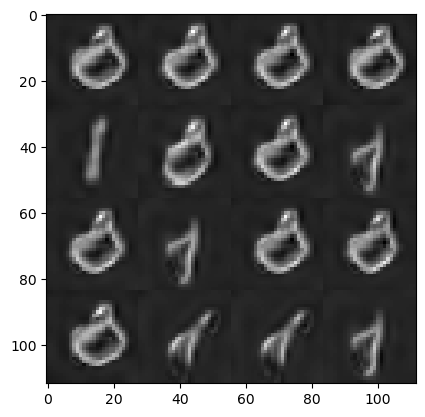

*** DONE WITH EPOCH 7  ***
	AVG loss discriminator:  0.1618946619294107
	AVG loss generator    :  3.4168239232065325


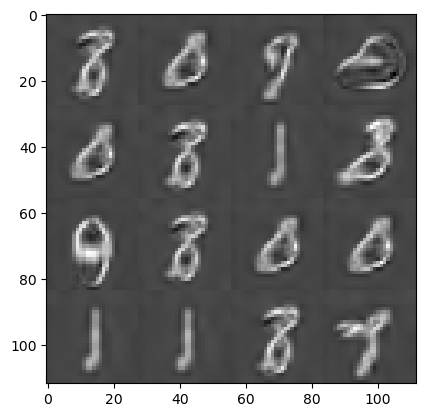

*** DONE WITH EPOCH 8  ***
	AVG loss discriminator:  0.15181631517948022
	AVG loss generator    :  3.0283989343307676


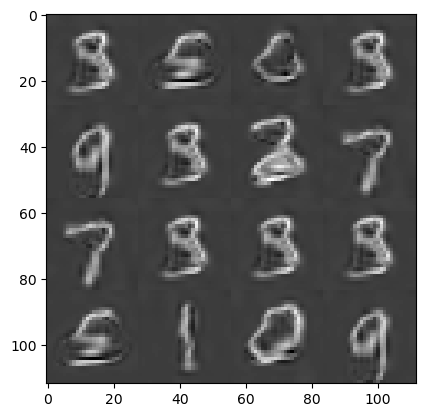

KeyboardInterrupt: 

In [28]:
#initialize the generator and discriminator
generator = Generator().to(DEVICE)
discriminator = Discriminator().to(DEVICE)

print("The generator has ", sum([p.numel() for p in generator.parameters()]), " parameters")
print("The discriminator has ", sum([p.numel() for p in discriminator.parameters()]), " parameters")

gen_opt = torch.optim.Adam(generator.parameters(), lr=0.0001)
disc_opt = torch.optim.Adam(discriminator.parameters(), lr=0.0001)

hard_relu = torch.nn.ReLU()

for epoch in range(0, 1000):
    step = 0
    loss_disc = 0
    loss_gen = 0
    for real, real_labels in train_loader:
        #1. put stuff on the GPU
        real = real.to(DEVICE)
        real_labels = real_labels.to(DEVICE)
        
        noise = torch.rand(real.size()[0], Z_DIMS, device=DEVICE) * 2.0 - 1.0 #noise in [-1, 1] is most stable
        fake_labels = torch.randint(0, 10, (real.size()[0],), device=DEVICE)
        
        #2. train the discriminator
        if True:
            discriminator.train(True)
            generator.train(False)
            disc_opt.zero_grad()
            #detach the generator output, so we do not backpropagate through the generator - 
            #we want to train the discriminator to distinguish between real and fake images, not to find some loopwhole in the generator
            fake = generator(noise, fake_labels).detach() 
            out_real = discriminator(real, real_labels)
            out_fake = discriminator(fake, fake_labels)

            #hinge loss: output -1 for fake, 1 for real images, but do not update anything if we are already correct enough (i.e. if a real is 1.5, we are already correct enough, don't update)
            #this is the "hinge" part: if we are already correct enough, we do not update the weights
            #aka the big "magic" to make GANs stable; traditional sigmoid on the output, then train to 1/0 is very unstable as the discriminator can easily "overpower" the generator 
            #--> what ever the generator outputs, it is so wrong that the discriminator can easily distinguish it and we have no gradients to update the generator

            #if real image is mapped to > 1, this clamps it to 0, if fake image is mapped to < -1, this clamps it to 0 ("don't update if we're good enough already" aka "wait for the generator to catch up")
            loss = hard_relu(1.0 - out_real).mean() + hard_relu(1.0 + out_fake).mean()
            loss_disc += loss.item()
            loss.backward()
            disc_opt.step()
        #3. train the generator
        if True:
            discriminator.train(False)
            generator.train(True)
            gen_opt.zero_grad()

            fake = generator(noise, fake_labels)
            out_fake = discriminator(fake, fake_labels)
            #train the generator to "fool" the discriminator; if the discriminator is already fooled enough, don't update the generator
            loss = hard_relu(1.0 - out_fake).mean()
            loss_gen += loss.item()
            loss.backward()
            gen_opt.step()
        
        step += 1
        if step == 1000: #don't wait for the whole dataset, we want to see stuff quickly...
            break

    print('*** DONE WITH EPOCH',epoch,' ***')
    print("\tAVG loss discriminator: ", loss_disc/step)
    print("\tAVG loss generator    : ", loss_gen /step)
    #show some example images
    with torch.no_grad():
        generator.eval()
        noise = torch.rand(16, Z_DIMS, device=DEVICE) * 2.0 - 1.0
        fake = generator(noise, torch.randint(0, 10, (16,), device=DEVICE)).cpu()
        #form of [16 x 1 x 28 x 28] - plot as 4x4 grid
        out = torch.zeros(1, 4*28, 4*28)
        #dumb loop is slow, but we don't care for just the output here
        for x in range(0, 4):
            for y in range(0, 4):
                out[0, x*28:(x+1)*28, y*28:(y+1)*28] = fake[x*4+y, 0]
        show(out)